Ce notebook est destiné à calculer les performances d'un modèle à base de réseaux de neurones basé sur différentes architectures avec des poids pré-entrainés ou pas.<br>
Pour des raisons liées à une instabilité mémoire du GPU sur cet environnement de test, chaque expérience rechargera un environnement après redémarrage du kernel pour éviter tout crash.<br>


# IMPORTS

In [1]:
import tensorflow as tf
import mlflow
import mlflow.tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pickle
import warnings

# import mlflow.keras
from gensim.models import KeyedVectors
from huggingface_hub import hf_hub_download
from tensorflow.config import list_physical_devices
import utils
import dl
import time

from tensorflow.keras.layers import (
    GlobalAveragePooling1D,
    GlobalMaxPool1D,
    Dropout,
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import (
    RandomUniform,
)
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Remove FutureWarning alerts
warnings.filterwarnings("ignore", category=FutureWarning)
# Check if GPU and CUDA are available
gpu = list_physical_devices("GPU")
print("Tensorflow framework: GPU is", "available" if gpu else "NOT AVAILABLE")

# Load the keras serialized func
%run register_serializable.ipynb

2025-01-13 08:17:25.342144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-13 08:17:27.463688: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2025-01-13 08:17:27.463745: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2025-01-13 08:17:27.469373: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
Dropped Escape call with ulEscapeCode : 0x03007703
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-13 08:17:27.661793: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


Tensorflow framework: GPU is available


# 1. Introduction

Je vais évaluer diffèrentes architectures de réseaux de neurones pour la classification de tweets en fonction de leur sentiment.<br>
Voici un résumé de la méthodologie que je vais suivre:

**Environnement de test**:<br>
Je vais utiliser un environnement GPU pour accélérer les calculs.<br>
Il est à noter que j'ai rencontré des problèmes de stabilité de la mémoire GPU sur cet environnement de test en raison du matériel utilisé et de DirectML.<br>
De ce fait, **j'ai décidé de limiter la taille des données et de recharger le kernel après chaque expérience pour éviter tout crash.**<br>
Le GPU utilisé est `AMD RADEON RX 6700 XT`. Ce dernier est uniquement compatible avec DirectML et non compatible avec les versions de ROCm.<br>
Concernant l'architecture `BI-LSTM`, le kernel avec DirectML ne fonctionne pas. J'utiliserai donc un kernel CPU pour cette expérience.<br>

**Jeu d'entrainement et de test**:<br>
J'utiliserai le jeu de données d'entrainement et de test déjà préparé à la fin de l'analyse exploratoire et d'avoir une base de travail comparable.<br>
A noter que le jeu de validation ici est un jeu de données unique et ne sera pas testé en validation croisée comme sur les modèles de machine learning classique.<br>
Le fichier `dl.py`contient les fonctions de préparation des datasets et de création du modèle.<br>
`Les datasets sont préparés pour le format tensorflow` pour accélerer les traitements.<br>

**Préparation des données - tokenisation**:<br>
J'ai décidé de conserver le même modèle de tokenisation que pour les modèles de machine learning classique pour garder une cohérence dans les résultats.<br>
Ce dernier a été enregistré en tant que modèle dans MLFlow pour pouvoir être réutilisé facilement.<br>
Toutefois, ici, j'utiliserai déjà les données préparées pour éviter de les recalculer à chaque fois.<br>
Les données brutes ont été tokenisées avec le modèle `en_core_web_sm` de Spacy sous deux différentes formes:
- **Données brutes**: Les données sont utilisées telles quelles.
- **Données lemmatisées**: Les données sont lemmatisées. Sachant que la lemmatisation est faite avec Spacy, cette étape a été intégrée dans la tokenisation.<br>

**Préparation des données - standardisation des textes**:<br>
J'utiliserai les mêmes fonctions de standardisation des textes que pour les modèles de machine learning classique pour garder une cohérence dans les résultats.<br>
Ces fonctions ont été adaptées pour tensorflow et seront intégrés dans le modèle sauvegardé dans MLFlow.<br>
Il est nécessaire de les réécrire pour les intégrer dans le modèle tensorflow et il est nécessaire de les enregistrer dans le modèle pour pouvoir les réutiliser facilement.<br>
Le fichier `func.py` contient les fonctions de standardisation des textes avec le décorateur nécessaire pour que ces dernières soient correctement enregistrées dans le modèle.<br>
Pour faciliter ici les expériences, je lance en même temps que les imports de package la lecture d'un notebook `register_serializable.ipynb` qui contient les fonctions de standardisation des textes.<br>


**Les architectures testées**:<br>
L'objectif est de partir vers une architecture simple vers une architecture plus complexe pour voir l'impact sur les performances du modèle.<br>


Le fichier `dl.py`contient la fonction `create_tf_model` intégre la couche de `vectorisation` et aussi `d'embedding` par défaut.<br>
Il contient également `la fonction de mapping pour les poids pré-entrainés`.<br>
Il est possible de rajouter d'autres couches dans les paramètres.<br>


Le fichier `utils.py` contient les fonctions génériques qui sont utilisées sur tous les notebooks.<br>
Il nous suffira uniquement de préciser les paramètres du modèle à tester et ceux concernant mlflow pour lancer les tests.<br>


Voici un résumé des architectures que je vais tester:
- `Modèle from scratch`: Un modèle simple avec une couche d'embedding sans poids pré-entrainés et une couche dense de classification à 2 classes en jouant sur plusieurs paramètres
- `Modèle avec poids pré-entrainés`: Un modèle simple avec une couche d'embedding avec des poids pré-entrainés et une couche dense de classification à 2 classes.
- `Modèle simple avec poids pré-entrainés et BI-LSTM`: Un modèle simple avec une couche d'embedding avec des poids pré-entrainés et une couche LSTM de classification à 2 classes.

# 2. Modèle from scratch

Pour commencer l'expérimentation sur le modèle from scratch, je vais commencer avec un modèle simple avec seulement une couche d'embedding et une couche de classification afin de voir quelle préparation perfome le mieux.<br>
Pour cette expérience et les suivantes, je testerai les six combinaisons suivantes :
- `Données brutes` ou `Données lemmatisées`
    - `Avec lowercase seulement`
    - `Avec lowercase et supression des mentions, hashtags et urls`
    - `Avec lowercase et supression des mentions, hashtags, urls et ponctuations ainsi que les chiffres`


Les poids de la couche d'embedding seront initialisés aléatoirement.<br>

## **Tokenized text, lowercase**

In [2]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "scratch",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 40,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 10,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": "lower",  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            GlobalAveragePooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D() )
    },
    "weights": {
        "pretrained_weights": None,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-12 16:06:23.070603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 16:06:23.071959: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 16:06:23.159172: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:06:23.159224: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-12 16:06:23.159255: I t

Vocabulary size:  29769


2025-01-12 16:06:29.834389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 16:06:29.913365: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:06:29.913415: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 16:06:29.914865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:06:29.914904: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2025-01-12 16:06:47.341964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 16:06:47.373733: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:06:47.373811: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 16:06:47.375210: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:06:47.375250: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1/1 [==============================] - 0s 61ms/step


2025-01-12 16:07:55.054524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /tmp/tmpn32k4cwh/model/data/model/assets
Evaluate on test data
186/186 [==============================] - 1s 3ms/step


2025-01-12 16:07:59.885480: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:07:59.885528: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 16:07:59.936508: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:07:59.936565: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: 

,negative,positive,macro avg
precision,0.763660,0.772930,0.768295
recall,0.778262,0.758086,0.768174
f1-score,0.770892,0.765436,0.768164
support,2981.000000,2968.000000,5949.000000


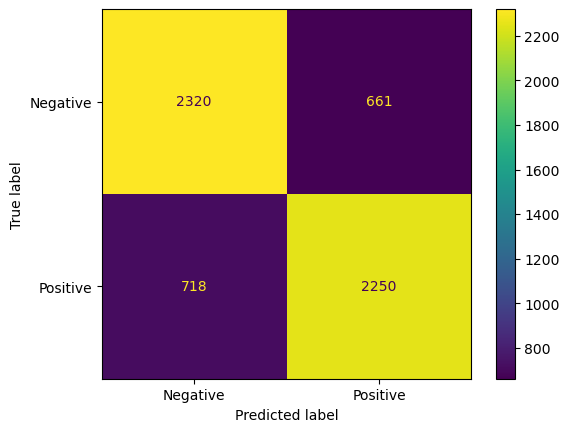

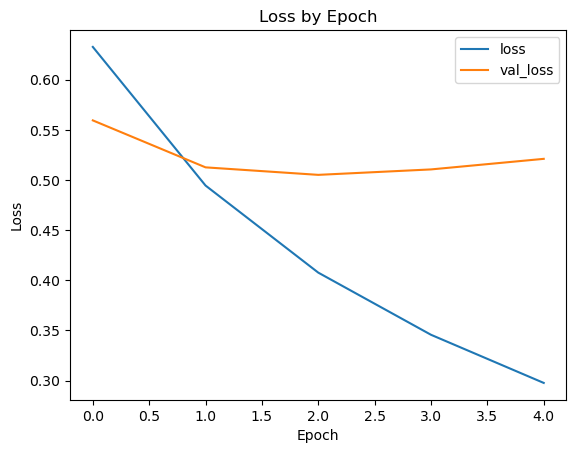

2025/01/12 16:08:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run scratch at: http://localhost:5000/#/experiments/9/runs/4296448cbb3947dd9ad59672045434e7.
2025/01/12 16:08:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


In [3]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": None,
        }
    )

## **Tokenized text, standardization 1**

In [2]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "scratch",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 40,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 10,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": dl.custom_standardization_punct,  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            GlobalAveragePooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D() )
    },
    "weights": {
        "pretrained_weights": None,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-12 16:16:37.547596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 16:16:37.548871: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 16:16:37.627362: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:16:37.627392: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-12 16:16:37.627413: I t

Vocabulary size:  20657


2025-01-12 16:16:45.171250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 16:16:45.233871: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:16:45.233920: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 16:16:45.235438: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:16:45.235476: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2025-01-12 16:16:57.228831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 16:16:57.261160: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:16:57.261208: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 16:16:57.262553: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:16:57.262590: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1/1 [==============================] - 0s 67ms/step


2025-01-12 16:17:44.431334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /tmp/tmpwplenqzc/model/data/model/assets


2025/01/12 16:17:47 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpwplenqzc/model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback. 


Evaluate on test data
186/186 [==============================] - 0s 2ms/step


2025-01-12 16:17:48.813215: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:17:48.813264: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 16:17:48.863443: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:17:48.863493: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: 

,negative,positive,macro avg
precision,0.767411,0.777969,0.772690
recall,0.783630,0.761456,0.772543
f1-score,0.775436,0.769624,0.772530
support,2981.000000,2968.000000,5949.000000


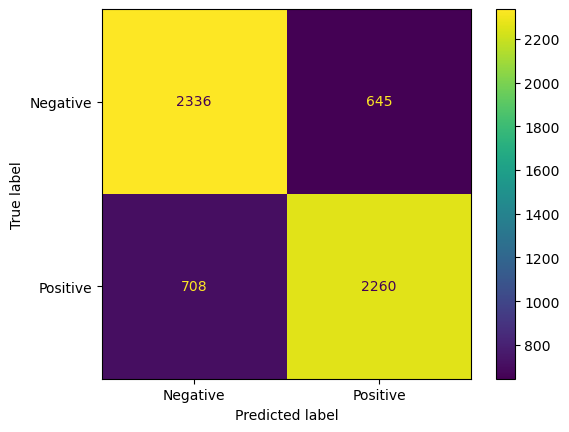

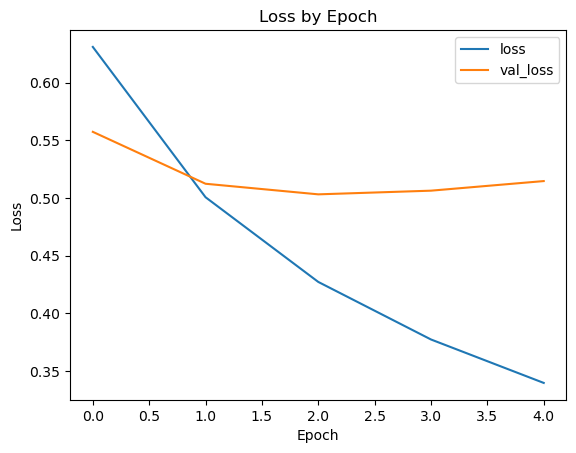

2025/01/12 16:17:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run scratch at: http://localhost:5000/#/experiments/9/runs/15c36d2a681f47219f7b77774ce43838.
2025/01/12 16:17:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


In [3]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": None,
        }
    )

## **Tokenized text, standardization 2**

In [2]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "scratch",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 40,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 10,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": dl.custom_standardization_nopunct_digits,  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            GlobalAveragePooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D() )
    },
    "weights": {
        "pretrained_weights": None,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-12 16:18:23.726909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 16:18:23.728176: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 16:18:23.800920: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:18:23.800952: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-12 16:18:23.800975: I t

Vocabulary size:  19483


2025-01-12 16:18:31.165313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 16:18:31.230104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:18:31.230152: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 16:18:31.231861: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:18:31.231898: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2025-01-12 16:18:41.674578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 16:18:41.707606: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:18:41.707658: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 16:18:41.709133: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:18:41.709171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1/1 [==============================] - 0s 70ms/step


2025-01-12 16:19:25.803120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /tmp/tmp6hgz341h/model/data/model/assets


2025/01/12 16:19:29 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp6hgz341h/model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback. 


Evaluate on test data
186/186 [==============================] - 1s 3ms/step


2025-01-12 16:19:30.427397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:19:30.427442: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 16:19:30.483123: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:19:30.483187: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: 

,negative,positive,macro avg
precision,0.767881,0.773984,0.770933
recall,0.777927,0.763814,0.770870
f1-score,0.772871,0.768866,0.770868
support,2981.000000,2968.000000,5949.000000


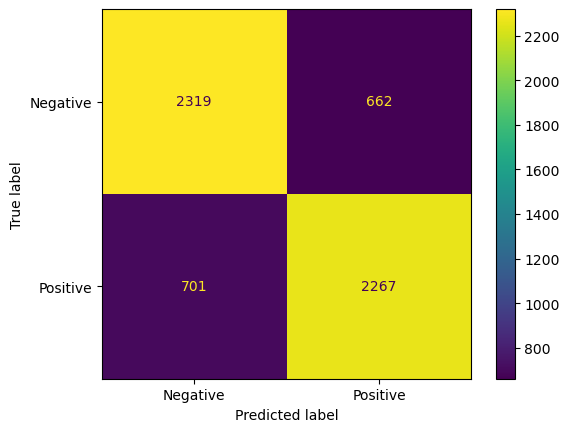

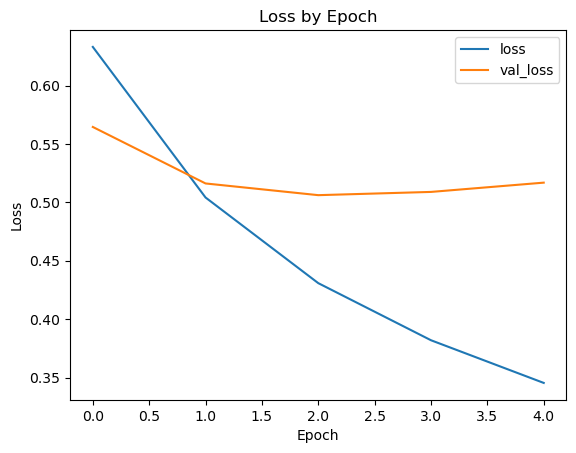

2025/01/12 16:19:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run scratch at: http://localhost:5000/#/experiments/9/runs/a892b91e61014b5b9bd9eea75dd98649.
2025/01/12 16:19:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


In [3]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": None,
        }
    )

## **Tokenized lemma text, lowercase**

In [2]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "scratch",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_lemma_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 35,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 10,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": "lower",  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            GlobalAveragePooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D() )
    },
    "weights": {
        "pretrained_weights": None,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-12 16:20:23.812002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 16:20:23.813115: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 16:20:23.889756: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:20:23.889783: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-12 16:20:23.889804: I t

Vocabulary size:  27490


2025-01-12 16:20:31.401117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 16:20:31.463776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:20:31.463827: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 16:20:31.465430: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:20:31.465467: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2025-01-12 16:20:45.643967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 16:20:45.674919: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:20:45.674966: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 16:20:45.676359: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:20:45.676396: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1/1 [==============================] - 0s 63ms/step


2025-01-12 16:21:44.570992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /tmp/tmpr3lnicmn/model/data/model/assets
Evaluate on test data
186/186 [==============================] - 1s 3ms/step


2025-01-12 16:21:48.881807: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:21:48.881867: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 16:21:48.933877: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:21:48.933928: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: 

,negative,positive,macro avg
precision,0.770586,0.764176,0.767381
recall,0.762831,0.771900,0.767366
f1-score,0.766689,0.768019,0.767354
support,2981.000000,2968.000000,5949.000000


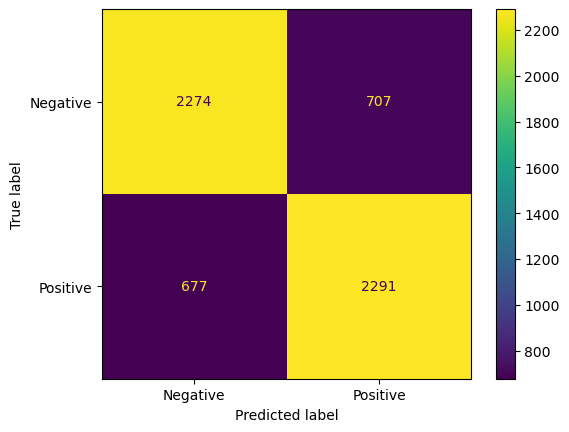

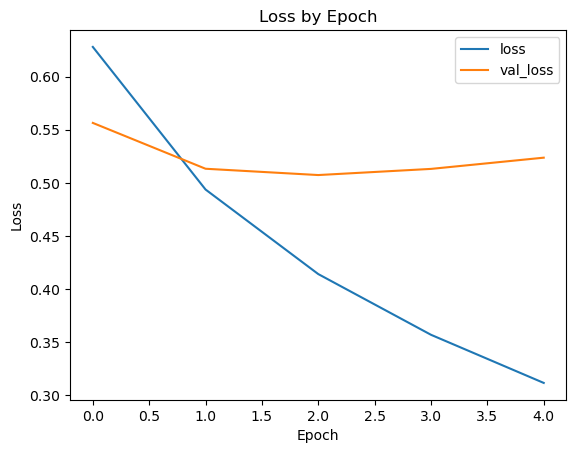

2025/01/12 16:21:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run scratch at: http://localhost:5000/#/experiments/9/runs/ab153f7ae7bd4d8192fec4a3343dd9cd.
2025/01/12 16:21:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


In [3]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": None,
        }
    )

## **Tokenized lemma text, standardization 1**

In [2]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "scratch",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_lemma_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 35,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 10,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": dl.custom_standardization_punct,  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            GlobalAveragePooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D() )
    },
    "weights": {
        "pretrained_weights": None,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-12 16:22:16.575731: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 16:22:16.576938: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 16:22:16.662223: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:22:16.662254: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-12 16:22:16.662278: I t

Vocabulary size:  18395


2025-01-12 16:22:23.612810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 16:22:23.682078: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:22:23.682130: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 16:22:23.683607: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:22:23.683647: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2025-01-12 16:22:33.871414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 16:22:33.905400: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:22:33.905453: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 16:22:33.906895: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:22:33.906934: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1/1 [==============================] - 0s 66ms/step


2025-01-12 16:23:14.499427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /tmp/tmpd1kkzi17/model/data/model/assets


2025/01/12 16:23:17 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpd1kkzi17/model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback. 


Evaluate on test data
186/186 [==============================] - 0s 3ms/step


2025-01-12 16:23:19.302728: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:23:19.302777: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 16:23:19.352968: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:23:19.353026: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: 

,negative,positive,macro avg
precision,0.769023,0.763703,0.766363
recall,0.762831,0.769879,0.766355
f1-score,0.765914,0.766779,0.766346
support,2981.000000,2968.000000,5949.000000


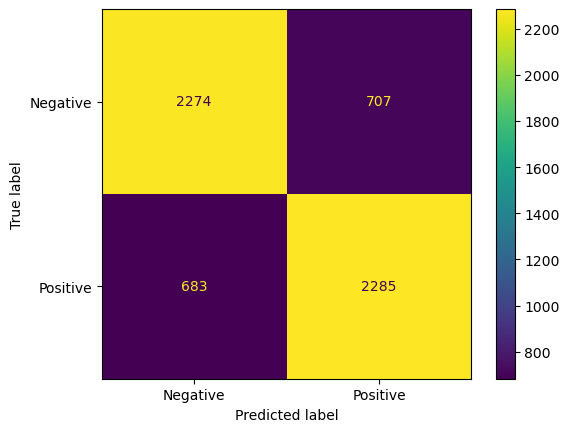

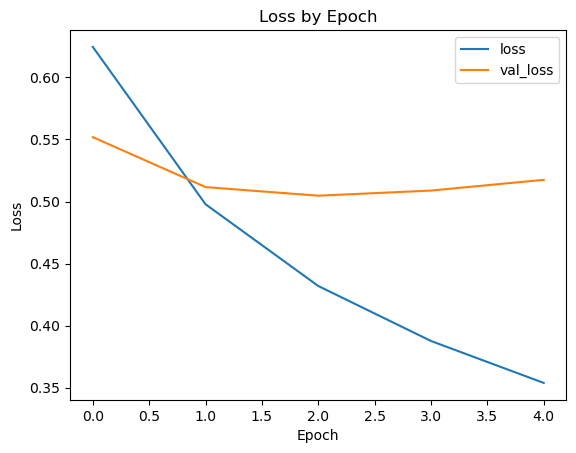

2025/01/12 16:23:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run scratch at: http://localhost:5000/#/experiments/9/runs/870c7349882d4e9d962130be4f346eb2.
2025/01/12 16:23:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


In [3]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": None,
        }
    )

## **Tokenized lemma text, standardization 2**

In [3]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "scratch",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_lemma_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 35,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 10,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": dl.custom_standardization_nopunct_digits,  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            GlobalAveragePooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D() )
    },
    "weights": {
        "pretrained_weights": None,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-12 16:24:02.586226: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 16:24:02.587639: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 16:24:02.666042: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:24:02.666076: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-12 16:24:02.666097: I t

Vocabulary size:  17249


2025-01-12 16:24:10.391392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 16:24:10.456341: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:24:10.456397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 16:24:10.457921: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:24:10.457959: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2025-01-12 16:24:19.806724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 16:24:19.839885: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:24:19.839937: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 16:24:19.841373: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:24:19.841412: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1/1 [==============================] - 0s 70ms/step


2025-01-12 16:24:57.061212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /tmp/tmpdd5d40cb/model/data/model/assets


2025/01/12 16:24:59 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpdd5d40cb/model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback. 


Evaluate on test data
186/186 [==============================] - 0s 3ms/step


2025-01-12 16:25:00.971925: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:25:00.971973: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 16:25:01.023836: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:25:01.023900: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: 

,negative,positive,macro avg
precision,0.770770,0.764000,0.767385
recall,0.762496,0.772237,0.767367
f1-score,0.766610,0.768097,0.767353
support,2981.000000,2968.000000,5949.000000


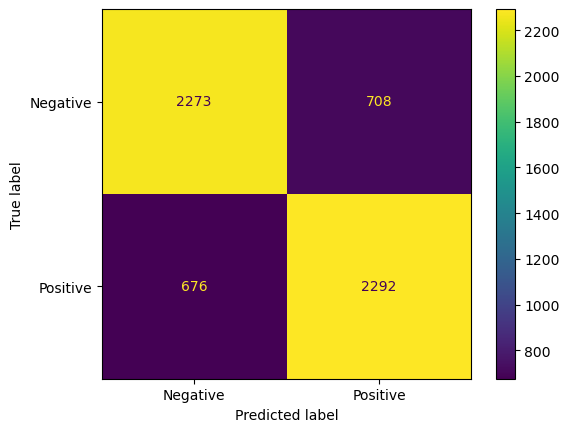

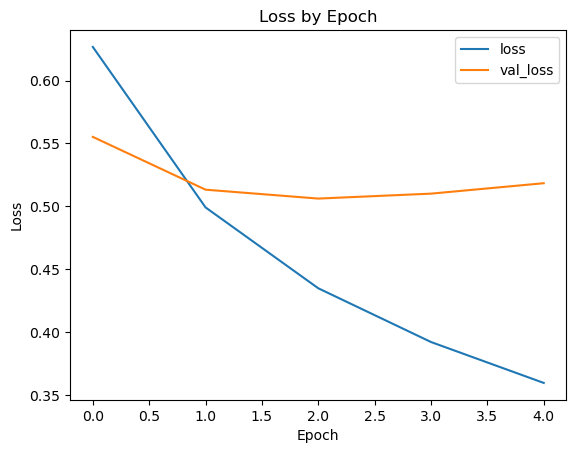

2025/01/12 16:25:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run scratch at: http://localhost:5000/#/experiments/9/runs/7b24862b1a3247668d3d0af79f9f0831.
2025/01/12 16:25:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


In [4]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Log the metrics and parameters
    # Convertir la liste de val_binary_accuracy en tableau NumPy
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": None,
        }
    )

## Tokenized text, standardization 2 + Max Pooling

In [2]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "scratch_maxpool",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 40,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 10,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": dl.custom_standardization_nopunct_digits,  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            GlobalMaxPool1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D() )
    },
    "weights": {
        "pretrained_weights": None,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-13 08:17:51.298244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-13 08:17:51.300053: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-13 08:17:51.387950: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-13 08:17:51.387987: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-13 08:17:51.388009: I t

Vocabulary size:  19483


2025-01-13 08:17:58.824788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-13 08:17:58.898213: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-13 08:17:58.898270: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-13 08:17:58.900679: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-13 08:17:58.900716: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2025-01-13 08:18:09.869706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-13 08:18:09.902466: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-13 08:18:09.902518: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-13 08:18:09.903981: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-13 08:18:09.904026: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1/1 [==============================] - 0s 65ms/step


2025-01-13 08:18:42.295674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /tmp/tmpmtxcfmsd/model/data/model/assets


2025/01/13 08:18:45 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpmtxcfmsd/model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback. 


Evaluate on test data
186/186 [==============================] - 0s 2ms/step


2025-01-13 08:18:46.200061: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-13 08:18:46.200109: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-13 08:18:46.250437: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-13 08:18:46.250490: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: 

,negative,positive,macro avg
precision,0.759247,0.766518,0.762883
recall,0.771218,0.754380,0.762799
f1-score,0.765186,0.760401,0.762793
support,2981.000000,2968.000000,5949.000000


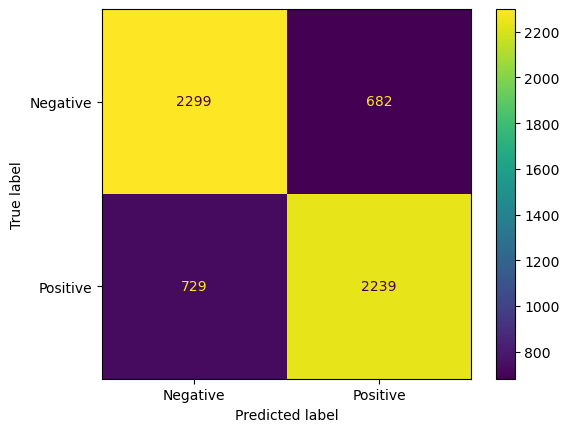

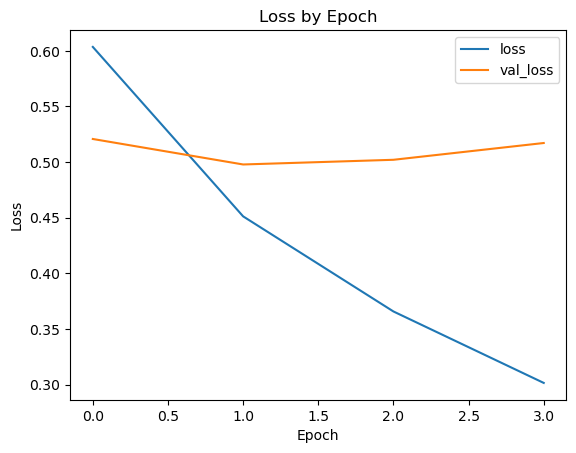

2025/01/13 08:18:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run scratch_maxpool at: http://localhost:5000/#/experiments/9/runs/955b18c8896b4300aaea299fe712e063.
2025/01/13 08:18:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


In [3]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": None,
        }
    )

## **Resultats**

In [6]:
# Récupération des résultats de l'expériementation
df_runs = utils.get_mlflow_results("p7_dl_models")
# Afficher les colonnes sélectionnées et filtrage des expériences
df_runs.loc[df_runs["param_pretrained_weights"] == "None", :].sort_values(
    ["metric_validation_loss"], ascending=True
).filter(
    [
        "param_pretrained_weights",
        "param_data_preparation",
        "param_standardization",
        "metric_validation_loss",
        "metric_val_accuracy",
        "metric_val_roc_auc",
        "metric_log_loss",
        "metric_accuracy_score",
        "metric_roc_auc",
        "metric_inference_time",
    ]
).head(6)


,param_pretrained_weights,param_data_preparation,param_standardization,metric_validation_loss,metric_val_accuracy,metric_val_roc_auc,metric_log_loss,metric_accuracy_score,metric_roc_auc,metric_inference_time
4,None,tokenized_text,<function custom_standardization_punct at 0x7f...,0.514637,0.763606,0.838891,0.498163,0.772567,0.841440,0.593581
3,None,tokenized_text,<function custom_standardization_nopunct_digit...,0.516842,0.765707,0.836770,0.498567,0.770886,0.840926,0.633666
1,None,tokenized_lemma_text,<function custom_standardization_punct at 0x7f...,0.517466,0.770330,0.837918,0.498622,0.766347,0.841028,0.616027
0,None,tokenized_lemma_text,<function custom_standardization_nopunct_digit...,0.518440,0.770120,0.836753,0.499914,0.767356,0.840088,0.617020
5,None,tokenized_text,lower,0.521047,0.765707,0.837864,0.498775,0.768196,0.840979,0.598014
2,None,tokenized_lemma_text,lower,0.523651,0.770330,0.836402,0.499682,0.767356,0.839916,0.610230


La préparation avec la fonction de standardisation de type 1 a le meilleur compromis sur les résultats (validation loss, accuracy sur le jeu de test et perte sur le jeu de test et aussi en temps d'inférence).<br>
Bien que le modèle est simple, il présente un bon compromis sur l'ensemble des métriques.<br>
Les résultats restent assez proches et l'augmentation de la taille du jeu de données permettrait d'augmenter la capacité du modèle et les performances.

# **Modèle avec poids glove-twitter-25**

## **Tokenized text, lowercase**

In [2]:
# Load the glove-twitter-25 model
repo_id = "fse/glove-twitter-25"
model_file = hf_hub_download(repo_id=repo_id, filename="glove-twitter-25.model")
vector_file = hf_hub_download(
    repo_id=repo_id, filename="glove-twitter-25.model.vectors.npy"
)
glove = KeyedVectors.load(model_file, mmap="r")

In [3]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "glove-25",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 40,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 25,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": "lower",  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            GlobalAveragePooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D() )
    },
    "weights": {
        "pretrained_weights": glove,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-12 17:16:05.643215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 17:16:05.644767: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 17:16:05.716121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:16:05.716149: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-12 17:16:05.716169: I t

Vocabulary size:  29769


2025-01-12 17:16:12.826550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 17:16:12.891469: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:16:12.891520: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:16:12.892966: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:16:12.893004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2025-01-12 17:16:51.109503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 17:16:51.141632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:16:51.141680: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:16:51.143054: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:16:51.143090: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1/1 [==============================] - 0s 64ms/step


2025-01-12 17:19:45.610952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /tmp/tmpe8n2g6ys/model/data/model/assets
Evaluate on test data
186/186 [==============================] - 1s 4ms/step


2025-01-12 17:19:53.632798: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:19:53.632962: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:19:53.703785: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:19:53.703844: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: 

,negative,positive,macro avg
precision,0.762823,0.776316,0.769569
recall,0.783294,0.755391,0.769343
f1-score,0.772923,0.765710,0.769317
support,2981.000000,2968.000000,5949.000000


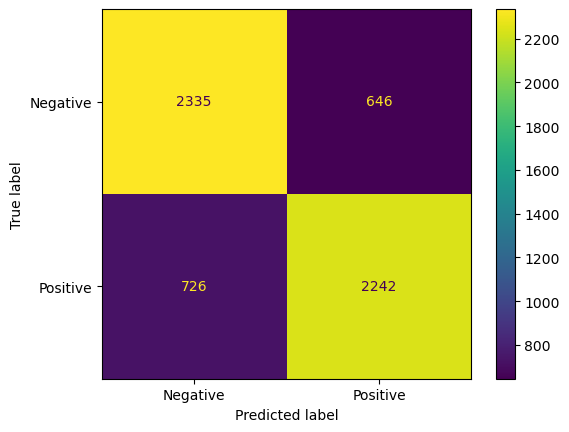

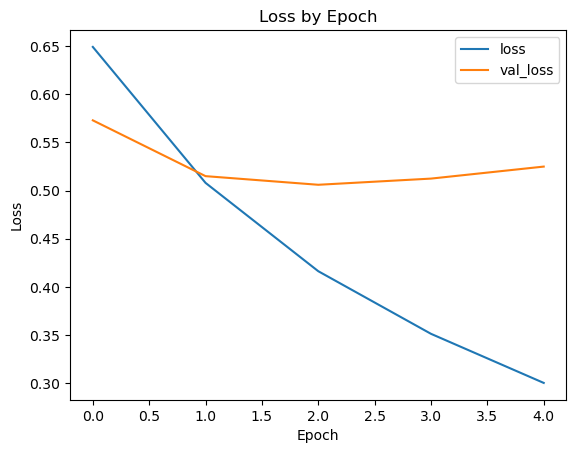

2025/01/12 17:19:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run glove-25 at: http://localhost:5000/#/experiments/9/runs/6c80775e36434b17ad0e1162465f605c.
2025/01/12 17:19:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


In [4]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": repo_id,
        }
    )

## **Tokenized text, standardization 1**

In [2]:
# Load the glove-twitter-25 model
repo_id = "fse/glove-twitter-25"
model_file = hf_hub_download(repo_id=repo_id, filename="glove-twitter-25.model")
vector_file = hf_hub_download(
    repo_id=repo_id, filename="glove-twitter-25.model.vectors.npy"
)
glove = KeyedVectors.load(model_file, mmap="r")

In [3]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "glove-25",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 40,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 25,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": dl.custom_standardization_punct,  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            GlobalAveragePooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D() )
    },
    "weights": {
        "pretrained_weights": glove,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-12 17:20:22.449752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 17:20:22.451233: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 17:20:22.525837: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:20:22.525875: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-12 17:20:22.525900: I t

Vocabulary size:  20657


2025-01-12 17:20:30.039344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 17:20:30.106389: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:20:30.106442: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:20:30.108722: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:20:30.108767: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2025-01-12 17:20:56.474862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 17:20:56.511045: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:20:56.511095: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:20:56.512781: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:20:56.512821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1/1 [==============================] - 0s 78ms/step


2025-01-12 17:22:39.330081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /tmp/tmpmg8t8mez/model/data/model/assets


2025/01/12 17:22:42 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpmg8t8mez/model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback. 


Evaluate on test data
186/186 [==============================] - 1s 3ms/step


2025-01-12 17:22:44.197874: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:22:44.197927: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:22:44.263418: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:22:44.263495: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: 

,negative,positive,macro avg
precision,0.763339,0.775743,0.769541
recall,0.782288,0.756402,0.769345
f1-score,0.772697,0.765950,0.769324
support,2981.000000,2968.000000,5949.000000


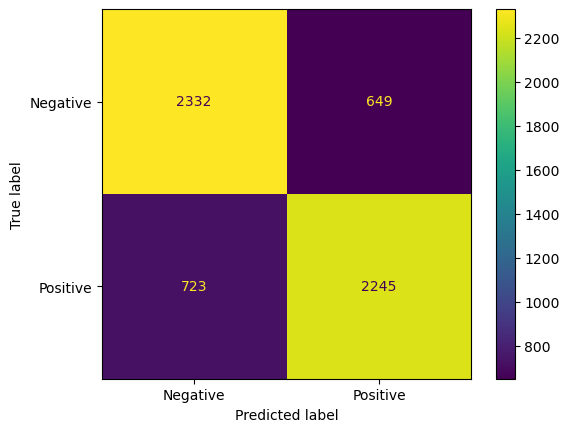

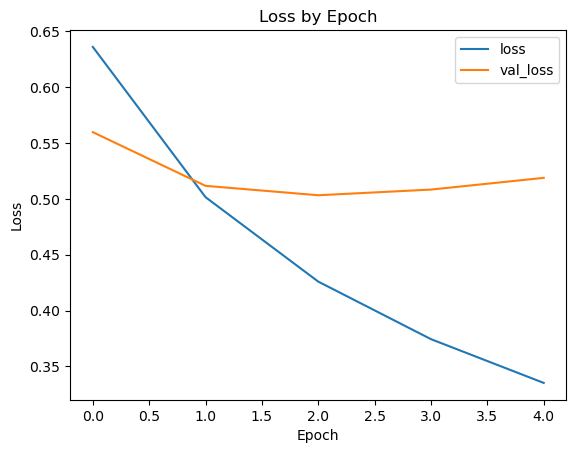

2025/01/12 17:22:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run glove-25 at: http://localhost:5000/#/experiments/9/runs/224847b8edd44e168f53b9a07c4db160.
2025/01/12 17:22:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


In [4]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": repo_id,
        }
    )

## **Tokenized text, standardization 2**

In [2]:
# Load the glove-twitter-25 model
repo_id = "fse/glove-twitter-25"
model_file = hf_hub_download(repo_id=repo_id, filename="glove-twitter-25.model")
vector_file = hf_hub_download(
    repo_id=repo_id, filename="glove-twitter-25.model.vectors.npy"
)
glove = KeyedVectors.load(model_file, mmap="r")

In [3]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "glove-25",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 40,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 25,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": dl.custom_standardization_nopunct_digits,  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            GlobalAveragePooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D() )
    },
    "weights": {
        "pretrained_weights": glove,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-12 17:23:22.039788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 17:23:22.041214: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 17:23:22.115746: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:23:22.115785: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-12 17:23:22.115809: I t

Vocabulary size:  19483


2025-01-12 17:23:29.918835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 17:23:29.984882: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:23:29.984944: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:23:29.987278: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:23:29.987322: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2025-01-12 17:23:53.190676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 17:23:53.224107: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:23:53.224156: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:23:53.226900: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:23:53.226954: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1/1 [==============================] - 0s 69ms/step


2025-01-12 17:25:26.997747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /tmp/tmpm3i_cn80/model/data/model/assets


2025/01/12 17:25:30 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpm3i_cn80/model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback. 


Evaluate on test data
186/186 [==============================] - 1s 3ms/step


2025-01-12 17:25:31.488640: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:25:31.488700: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:25:31.543111: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:25:31.543202: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: 

,negative,positive,macro avg
precision,0.769463,0.768272,0.768868
recall,0.769205,0.768531,0.768868
f1-score,0.769334,0.768402,0.768868
support,2981.000000,2968.000000,5949.000000


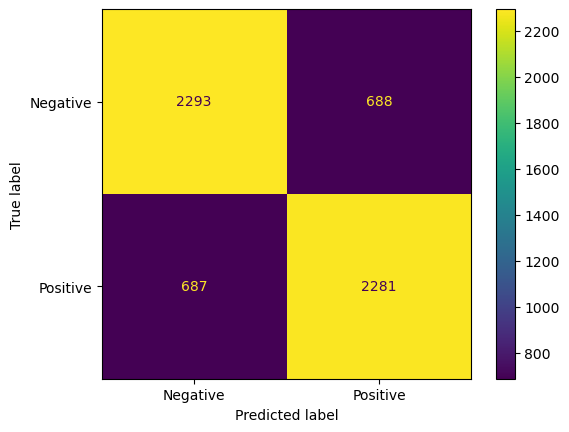

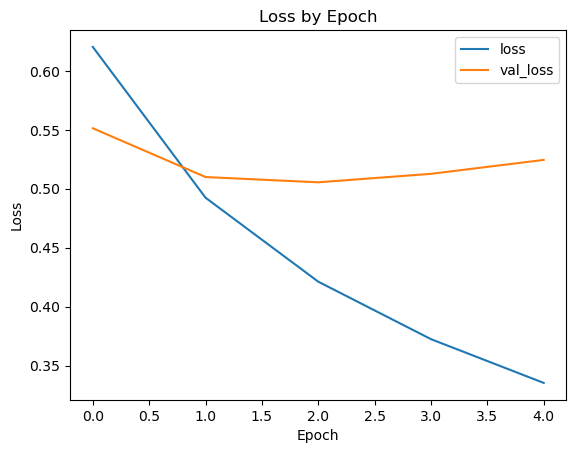

2025/01/12 17:25:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run glove-25 at: http://localhost:5000/#/experiments/9/runs/bf5be988df4843fc91a0fffd56facb74.
2025/01/12 17:25:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


In [4]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
        }
    )

## **Tokenized lemma text, lower**

In [2]:
# Load the glove-twitter-25 model
repo_id = "fse/glove-twitter-25"
model_file = hf_hub_download(repo_id=repo_id, filename="glove-twitter-25.model")
vector_file = hf_hub_download(
    repo_id=repo_id, filename="glove-twitter-25.model.vectors.npy"
)
glove = KeyedVectors.load(model_file, mmap="r")

In [3]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "glove-25",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_lemma_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 35,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 25,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": "lower",  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            GlobalAveragePooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D() )
    },
    "weights": {
        "pretrained_weights": glove,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

In [ ]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
        }
    )

2025-01-12 13:48:29.883143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 13:48:29.884490: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 13:48:29.966167: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 13:48:29.966203: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-12 13:48:29.966227: I t

Vocabulary size:  29769


2025-01-12 13:48:37.303606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 13:48:37.366501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 13:48:37.366561: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 13:48:37.368458: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 13:48:37.368500: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2025-01-12 13:48:54.760072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 13:48:54.796030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 13:48:54.796087: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 13:48:54.797606: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 13:48:54.797643: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

## **Tokenized lemma text, standardization 1**

In [2]:
# Load the glove-twitter-25 model
repo_id = "fse/glove-twitter-25"
model_file = hf_hub_download(repo_id=repo_id, filename="glove-twitter-25.model")
vector_file = hf_hub_download(
    repo_id=repo_id, filename="glove-twitter-25.model.vectors.npy"
)
glove = KeyedVectors.load(model_file, mmap="r")

In [3]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "glove-25",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_lemma_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 35,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 25,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": dl.custom_standardization_punct,  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            GlobalAveragePooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D() )
    },
    "weights": {
        "pretrained_weights": glove,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-12 17:37:49.133245: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 17:37:49.134548: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 17:37:49.205631: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:37:49.205662: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-12 17:37:49.205685: I t

Vocabulary size:  18395


2025-01-12 17:37:56.840785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 17:37:56.904392: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:37:56.904445: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:37:56.906178: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:37:56.906219: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2025-01-12 17:38:18.778585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 17:38:18.810552: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:38:18.810611: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:38:18.812136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:38:18.812174: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1/1 [==============================] - 0s 68ms/step


2025-01-12 17:39:44.947764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /tmp/tmpfjvza0z9/model/data/model/assets


2025/01/12 17:39:48 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpfjvza0z9/model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback. 


Evaluate on test data
186/186 [==============================] - 0s 3ms/step


2025-01-12 17:39:49.739105: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:39:49.739166: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:39:49.793531: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:39:49.793599: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: 

,negative,positive,macro avg
precision,0.773713,0.767434,0.770573
recall,0.766186,0.774933,0.770559
f1-score,0.769931,0.771165,0.770548
support,2981.000000,2968.000000,5949.000000


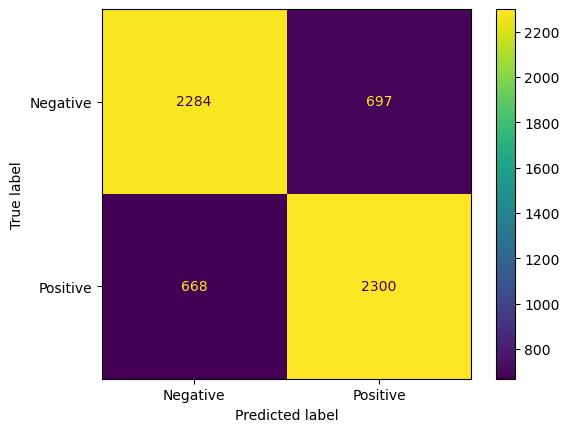

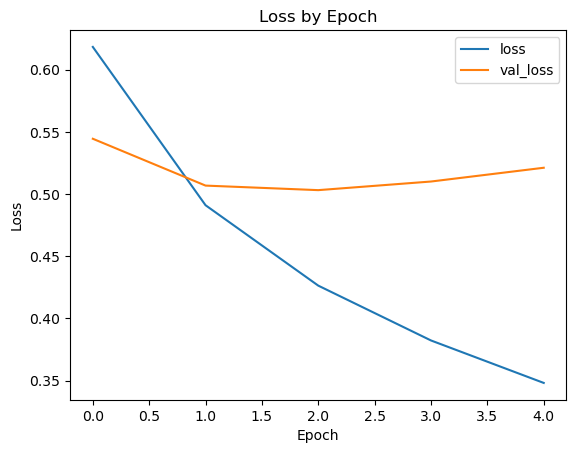

2025/01/12 17:39:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run glove-25 at: http://localhost:5000/#/experiments/9/runs/8b4a5daf466547e79ce6a909c5c815a9.
2025/01/12 17:39:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


In [4]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": repo_id,
        }
    )

## **Tokenized lemma text, standardization 2**

In [2]:
# Load the glove-twitter-25 model
repo_id = "fse/glove-twitter-25"
model_file = hf_hub_download(repo_id=repo_id, filename="glove-twitter-25.model")
vector_file = hf_hub_download(
    repo_id=repo_id, filename="glove-twitter-25.model.vectors.npy"
)
glove = KeyedVectors.load(model_file, mmap="r")

In [3]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "glove-25",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_lemma_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 35,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 25,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": dl.custom_standardization_nopunct_digits,  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            GlobalAveragePooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D() )
    },
    "weights": {
        "pretrained_weights": glove,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

In [ ]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": repo_id,
        }
    )

2025-01-12 13:48:29.883143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 13:48:29.884490: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 13:48:29.966167: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 13:48:29.966203: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-12 13:48:29.966227: I t

Vocabulary size:  29769


2025-01-12 13:48:37.303606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 13:48:37.366501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 13:48:37.366561: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 13:48:37.368458: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 13:48:37.368500: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2025-01-12 13:48:54.760072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 13:48:54.796030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 13:48:54.796087: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 13:48:54.797606: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 13:48:54.797643: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

## Resultats

In [17]:
# Récupération des résultats de l'expériementation
df_runs = utils.get_mlflow_results("p7_dl_models")
# Afficher les colonnes sélectionnées et filtrage des expériences
df_runs.loc[df_runs["tag_mlflow.runName"] == "glove-25", :].sort_values(
    ["metric_validation_loss"], ascending=True
).filter(
    [
        "param_pretrained_weights",
        "param_data_preparation",
        "param_standardization",
        "metric_validation_loss",
        "metric_val_accuracy",
        "metric_val_roc_auc",
        "metric_log_loss",
        "metric_accuracy_score",
        "metric_roc_auc",
        "metric_inference_time",
    ]
).head(10)


,param_pretrained_weights,param_data_preparation,param_standardization,metric_validation_loss,metric_val_accuracy,metric_val_roc_auc,metric_log_loss,metric_accuracy_score,metric_roc_auc,metric_inference_time
15,fse/glove-twitter-25,tokenized_text,<function custom_standardization_punct at 0x7f...,0.518787,0.765917,0.839513,0.497883,0.769373,0.841778,0.643906
13,fse/glove-twitter-25,tokenized_lemma_text,<function custom_standardization_punct at 0x7f...,0.521188,0.770330,0.840820,0.496190,0.770550,0.843864,0.626339
14,NaN,tokenized_text,<function custom_standardization_nopunct_digit...,0.524461,0.765707,0.838508,0.497346,0.768869,0.842359,0.633592
16,fse/glove-twitter-25,tokenized_text,lower,0.524896,0.766337,0.837351,0.500322,0.769373,0.840298,0.780951


On ne constate pas d'amélioration notable sur les résultats avec les poids pré-entrainés.<br>
Cela peut s'expliquer que l'argot dans les tweets n'est pas forcément présent dans les données d'entrainement des poids pré-entrainés.<br>
Au final, le modèle from sractch a mieux généralisé sur ce vocabulaire particulier.<br>
Il serait nécessaire d'adapter le learning rate pour améliorer les résultats mais cela prendrait bien plus de temps.<br>
On a constaté sur les courbes à nouveau un problème de sur-apprentissage et le fait d'augmenter les capacités du modèle avec une embedding de dimension 25 n'a pas amélioré les résultats, voir a été contre-performant.<br>
Le temps d'entrainement est plus long avec les poids pré-entrainés ainsi que le temps d'inférence.<br>
Encore une fois le type de standardisation 1 est le plus performant.<br>

# **Modèle avec poids paragram-25**

## **Tokenized text, lowercase**

In [2]:
# Load a word2vec model
embedding_name = "paragram-25"
repo_id = f"fse/{embedding_name}"
model_file = hf_hub_download(repo_id=repo_id, filename=f"{embedding_name}.model")
paragram = KeyedVectors.load(model_file, mmap="r")

In [3]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "paragram-25",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 40,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 25,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": "lower",  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            GlobalAveragePooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D() )
    },
    "weights": {
        "pretrained_weights": paragram,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-12 17:43:40.578877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 17:43:40.580228: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 17:43:40.659063: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:43:40.659096: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-12 17:43:40.659121: I t

Vocabulary size:  29769


2025-01-12 17:43:48.108690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 17:43:48.172378: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:43:48.172431: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:43:48.174015: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:43:48.174057: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2025-01-12 17:44:26.542796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 17:44:26.573228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:44:26.573285: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:44:26.575470: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:44:26.575528: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1/1 [==============================] - 0s 64ms/step


2025-01-12 17:46:20.053951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /tmp/tmp3fivvy25/model/data/model/assets
Evaluate on test data
186/186 [==============================] - 1s 3ms/step


2025-01-12 17:46:24.761699: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:46:24.761753: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:46:24.818587: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:46:24.818664: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: 

,negative,positive,macro avg
precision,0.769595,0.764804,0.767199
recall,0.764173,0.770216,0.767194
f1-score,0.766874,0.767500,0.767187
support,2981.000000,2968.000000,5949.000000


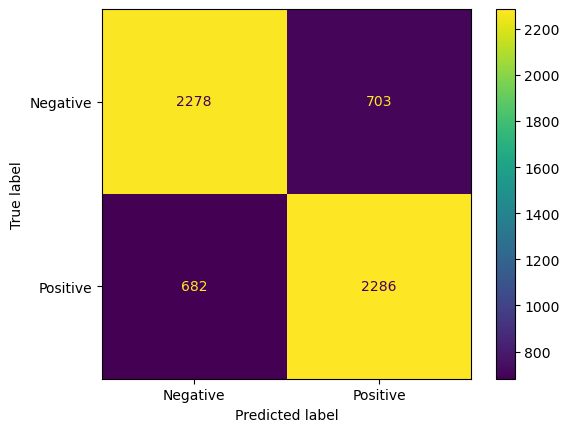

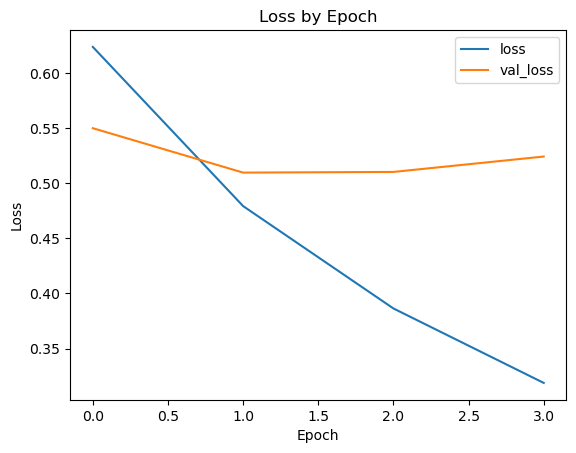

2025/01/12 17:46:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run paragram-25 at: http://localhost:5000/#/experiments/9/runs/5a89bc4f14a749d1ae1ab4abf8f36fcc.
2025/01/12 17:46:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


In [4]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": repo_id,
        }
    )

## **Tokenized text, standardization 1**

In [2]:
# Load a word2vec model
embedding_name = "paragram-25"
repo_id = f"fse/{embedding_name}"
model_file = hf_hub_download(repo_id=repo_id, filename=f"{embedding_name}.model")
paragram = KeyedVectors.load(model_file, mmap="r")

In [3]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "paragram-25",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 40,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 25,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": dl.custom_standardization_punct,  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            GlobalAveragePooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D() )
    },
    "weights": {
        "pretrained_weights": paragram,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-12 17:46:46.486175: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 17:46:46.487688: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 17:46:46.567571: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:46:46.567604: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-12 17:46:46.567627: I t

Vocabulary size:  20657


2025-01-12 17:46:53.862989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 17:46:53.939548: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:46:53.939621: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:46:53.941556: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:46:53.941600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2025-01-12 17:47:20.299882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 17:47:20.334784: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:47:20.334841: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:47:20.336335: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:47:20.336373: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1/1 [==============================] - 0s 66ms/step


2025-01-12 17:49:03.076392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /tmp/tmpr1jd564z/model/data/model/assets


2025/01/12 17:49:06 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpr1jd564z/model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback. 


Evaluate on test data
186/186 [==============================] - 1s 3ms/step


2025-01-12 17:49:07.550605: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:49:07.550660: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:49:07.605077: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:49:07.605134: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: 

,negative,positive,macro avg
precision,0.764319,0.773617,0.768968
recall,0.778933,0.758760,0.768847
f1-score,0.771557,0.766117,0.768837
support,2981.000000,2968.000000,5949.000000


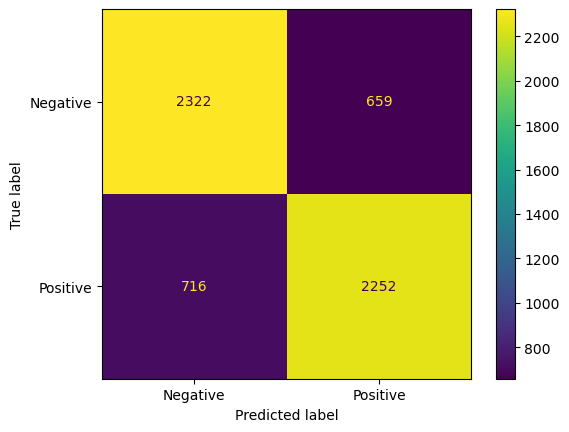

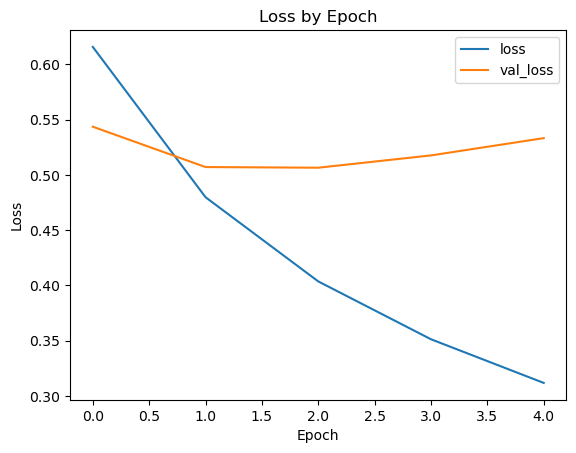

2025/01/12 17:49:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run paragram-25 at: http://localhost:5000/#/experiments/9/runs/fc9c0fd6721f448b88b9502576f8119c.
2025/01/12 17:49:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


In [4]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": repo_id,
        }
    )

## **Tokenized text, standardization 2**

In [2]:
# Load a word2vec model
embedding_name = "paragram-25"
repo_id = f"fse/{embedding_name}"
model_file = hf_hub_download(repo_id=repo_id, filename=f"{embedding_name}.model")
paragram = KeyedVectors.load(model_file, mmap="r")

In [3]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "paragram-25",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 40,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 25,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": dl.custom_standardization_nopunct_digits,  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            GlobalAveragePooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D() )
    },
    "weights": {
        "pretrained_weights": paragram,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-12 17:49:53.776185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 17:49:53.777978: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 17:49:53.857648: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:49:53.857681: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-12 17:49:53.857707: I t

Vocabulary size:  19483


2025-01-12 17:50:01.010419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 17:50:01.076105: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:50:01.076189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:50:01.078095: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:50:01.078139: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2025-01-12 17:50:24.862461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 17:50:24.895904: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:50:24.895954: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:50:24.897480: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:50:24.897519: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1/1 [==============================] - 0s 67ms/step


2025-01-12 17:51:58.730377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /tmp/tmpszfj3zro/model/data/model/assets


2025/01/12 17:52:02 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpszfj3zro/model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback. 


Evaluate on test data
186/186 [==============================] - 1s 3ms/step


2025-01-12 17:52:03.254714: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:52:03.254766: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:52:03.308918: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:52:03.308982: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: 

,negative,positive,macro avg
precision,0.765859,0.770252,0.768055
recall,0.773566,0.762466,0.768016
f1-score,0.769693,0.766339,0.768016
support,2981.000000,2968.000000,5949.000000


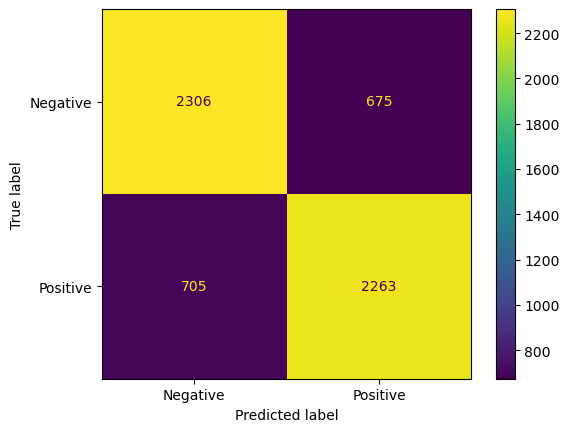

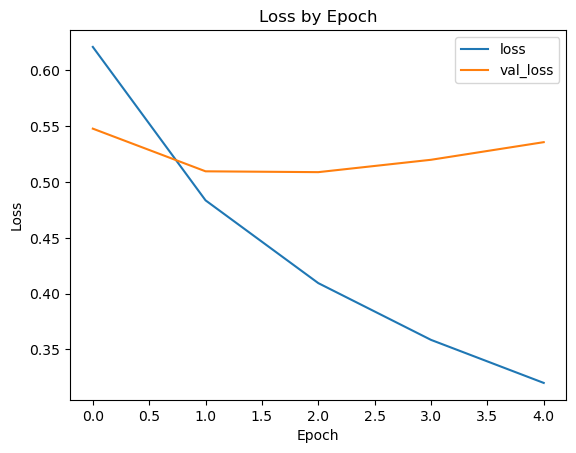

2025/01/12 17:52:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run paragram-25 at: http://localhost:5000/#/experiments/9/runs/5c701481b5544bcaa0d9251fbd2f450d.
2025/01/12 17:52:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


In [4]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": repo_id,
        }
    )

## **Tokenized lemma text, lower**

In [2]:
# Load a word2vec model
embedding_name = "paragram-25"
repo_id = f"fse/{embedding_name}"
model_file = hf_hub_download(repo_id=repo_id, filename=f"{embedding_name}.model")
paragram = KeyedVectors.load(model_file, mmap="r")

In [3]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "paragram-25",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_lemma_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 35,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 25,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": "lower",  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            GlobalAveragePooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D() )
    },
    "weights": {
        "pretrained_weights": paragram,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-12 17:55:50.157194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 17:55:50.158826: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 17:55:50.239685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:55:50.239720: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-12 17:55:50.239747: I t

Vocabulary size:  27490


2025-01-12 17:55:58.385345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 17:55:58.447497: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:55:58.447551: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:55:58.449092: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:55:58.449135: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1/1 [==============================] - 0s 63ms/step


2025-01-12 17:58:10.159201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /tmp/tmpa427ob93/model/data/model/assets
Evaluate on test data
186/186 [==============================] - 1s 3ms/step


2025-01-12 17:58:14.437117: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:58:14.437179: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:58:14.489538: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:58:14.489592: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: 

,negative,positive,macro avg
precision,0.775105,0.753976,0.764540
recall,0.745723,0.782682,0.764202
f1-score,0.760130,0.768061,0.764095
support,2981.000000,2968.000000,5949.000000


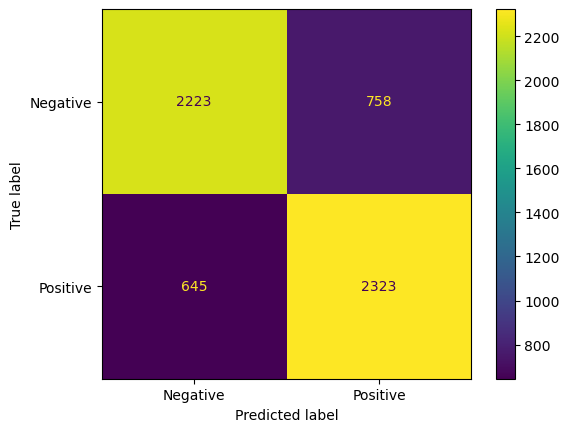

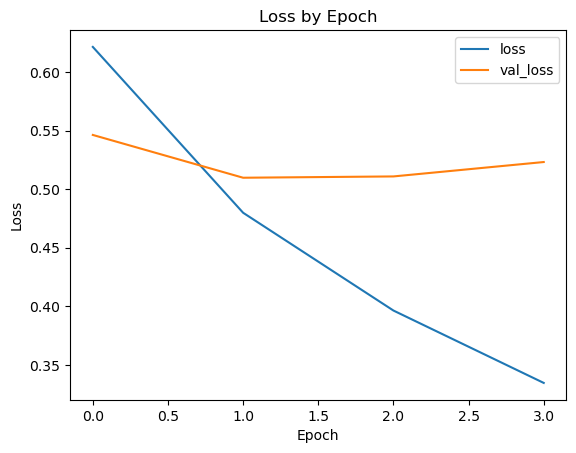

2025/01/12 17:58:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run paragram-25 at: http://localhost:5000/#/experiments/9/runs/fa3a75de7c054f8fadc5b153467bd7c7.
2025/01/12 17:58:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


In [4]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": repo_id,
        }
    )

## **Tokenized lemma text, standardization 1**

In [2]:
# Load a word2vec model
embedding_name = "paragram-25"
repo_id = f"fse/{embedding_name}"
model_file = hf_hub_download(repo_id=repo_id, filename=f"{embedding_name}.model")
paragram = KeyedVectors.load(model_file, mmap="r")

In [3]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "paragram-25",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_lemma_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 35,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 25,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": dl.custom_standardization_punct,  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            GlobalAveragePooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D() )
    },
    "weights": {
        "pretrained_weights": paragram,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-12 17:58:49.389633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 17:58:49.390908: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 17:58:49.470905: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:58:49.470939: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-12 17:58:49.470963: I t

Vocabulary size:  18395


2025-01-12 17:58:57.100248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 17:58:57.166292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:58:57.166344: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:58:57.167890: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:58:57.167931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2025-01-12 17:59:18.428234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 17:59:18.462612: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:59:18.462670: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 17:59:18.464224: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 17:59:18.464267: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1/1 [==============================] - 0s 68ms/step


2025-01-12 18:00:23.451459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /tmp/tmp5e5rd5k4/model/data/model/assets


2025/01/12 18:00:26 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp5e5rd5k4/model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback. 


Evaluate on test data
186/186 [==============================] - 1s 3ms/step


2025-01-12 18:00:28.168226: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 18:00:28.168278: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 18:00:28.221111: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 18:00:28.221169: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: 

,negative,positive,macro avg
precision,0.770335,0.759510,0.764923
recall,0.756122,0.773585,0.764854
f1-score,0.763162,0.766483,0.764823
support,2981.000000,2968.000000,5949.000000


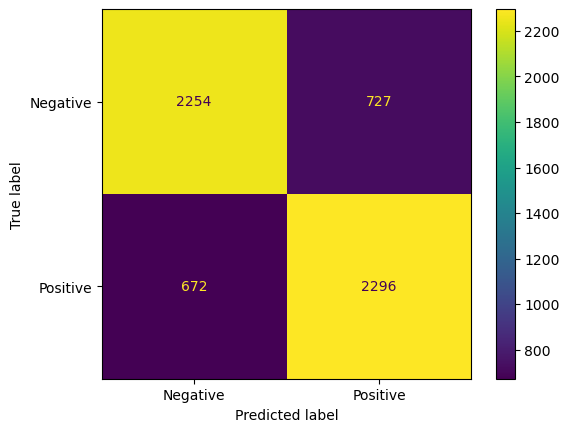

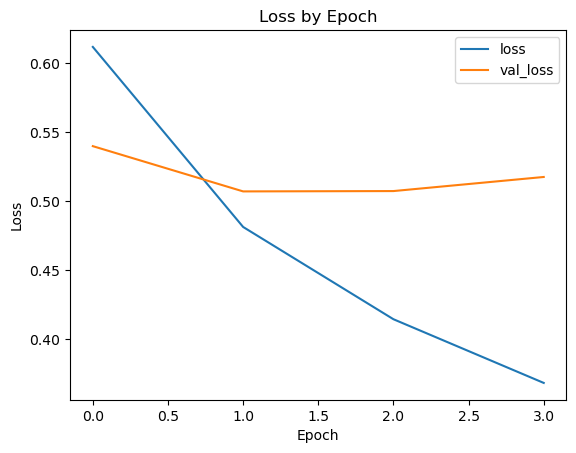

2025/01/12 18:00:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run paragram-25 at: http://localhost:5000/#/experiments/9/runs/55d90607fa894ae79d0da9c8638a3fb3.
2025/01/12 18:00:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


In [4]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": repo_id,
        }
    )

In [ ]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Log the metrics and parameters
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][-1],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][-1],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][-1],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
        }
    )

2025-01-12 13:48:29.883143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 13:48:29.884490: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 13:48:29.966167: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 13:48:29.966203: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-12 13:48:29.966227: I t

Vocabulary size:  29769


2025-01-12 13:48:37.303606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 13:48:37.366501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 13:48:37.366561: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 13:48:37.368458: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 13:48:37.368500: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2025-01-12 13:48:54.760072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 13:48:54.796030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 13:48:54.796087: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 13:48:54.797606: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 13:48:54.797643: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

## **Tokenized lemma text, standardization 2**

In [2]:
# Load a word2vec model
embedding_name = "paragram-25"
repo_id = f"fse/{embedding_name}"
model_file = hf_hub_download(repo_id=repo_id, filename=f"{embedding_name}.model")
paragram = KeyedVectors.load(model_file, mmap="r")

In [3]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "paragram-25",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_lemma_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 35,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 25,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": dl.custom_standardization_nopunct_digits,  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            GlobalAveragePooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D() )
    },
    "weights": {
        "pretrained_weights": paragram,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-12 18:01:43.190287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 18:01:43.191804: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 18:01:43.273111: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 18:01:43.273144: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:37] Ignoring the value of TF_FORCE_GPU_ALLOW_GROWTH because force_memory_growth was requested by the device.
2025-01-12 18:01:43.273167: I t

Vocabulary size:  17249


2025-01-12 18:01:51.192079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 18:01:51.256487: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 18:01:51.256548: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 18:01:51.258212: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 18:01:51.258251: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2025-01-12 18:02:10.462702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-12 18:02:10.496277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 18:02:10.496327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 18:02:10.497849: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 18:02:10.497893: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1/1 [==============================] - 0s 70ms/step


2025-01-12 18:03:09.514138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /tmp/tmpx9x00eqa/model/data/model/assets


2025/01/12 18:03:12 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpx9x00eqa/model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback. 


Evaluate on test data
186/186 [==============================] - 1s 3ms/step


2025-01-12 18:03:13.939437: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 18:03:13.939489: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2025-01-12 18:03:13.993564: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 18:03:13.993637: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: 

,negative,positive,macro avg
precision,0.781195,0.752885,0.767040
recall,0.741362,0.791442,0.766402
f1-score,0.760757,0.771682,0.766220
support,2981.000000,2968.000000,5949.000000


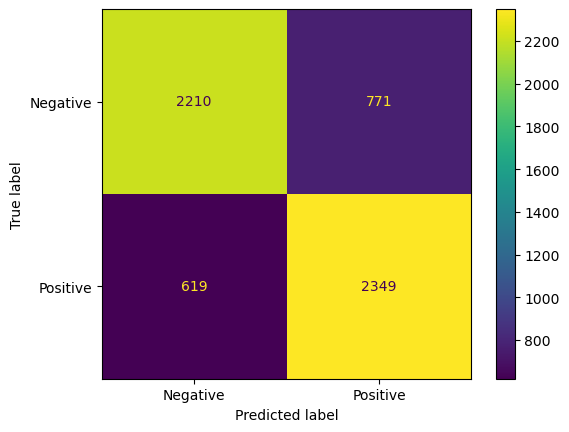

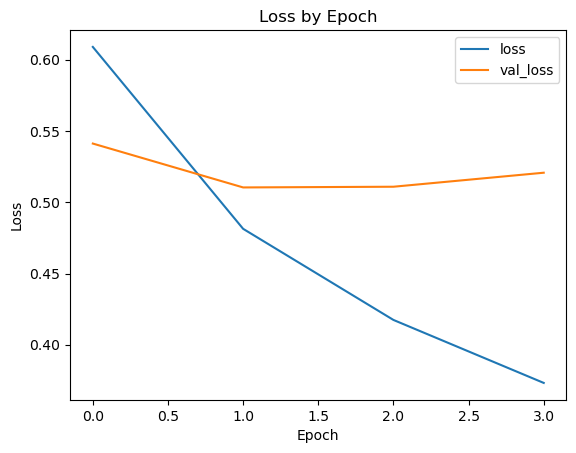

2025/01/12 18:03:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run paragram-25 at: http://localhost:5000/#/experiments/9/runs/006cb4d0ab1d46af972dae246ac330fd.
2025/01/12 18:03:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


In [4]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": repo_id,
        }
    )

## Résultats

In [18]:
# Récupération des résultats de l'expériementation
df_runs = utils.get_mlflow_results("p7_dl_models")
# Afficher les colonnes sélectionnées et filtrage des expériences
df_runs.loc[df_runs["tag_mlflow.runName"] == "paragram-25", :].sort_values(
    ["metric_validation_loss"], ascending=True
).filter(
    [
        "param_pretrained_weights",
        "param_data_preparation",
        "param_standardization",
        "metric_validation_loss",
        "metric_val_accuracy",
        "metric_val_roc_auc",
        "metric_log_loss",
        "metric_accuracy_score",
        "metric_roc_auc",
        "metric_inference_time",
    ]
).head(10)

,param_pretrained_weights,param_data_preparation,param_standardization,metric_validation_loss,metric_val_accuracy,metric_val_roc_auc,metric_log_loss,metric_accuracy_score,metric_roc_auc,metric_inference_time
8,fse/paragram-25,tokenized_lemma_text,<function custom_standardization_punct at 0x7f...,0.517474,0.765497,0.835734,0.501231,0.764834,0.839459,0.625698
7,fse/paragram-25,tokenized_lemma_text,<function custom_standardization_nopunct_digit...,0.520726,0.767388,0.833936,0.501935,0.766347,0.838820,0.631941
9,fse/paragram-25,tokenized_lemma_text,lower,0.523123,0.763816,0.834647,0.504411,0.764162,0.837140,0.632403
12,fse/paragram-25,tokenized_text,lower,0.524175,0.760664,0.833848,0.505292,0.767188,0.836124,0.623723
11,fse/paragram-25,tokenized_text,<function custom_standardization_punct at 0x7f...,0.533217,0.764867,0.838875,0.496939,0.768869,0.843458,0.636124
10,fse/paragram-25,tokenized_text,<function custom_standardization_nopunct_digit...,0.535740,0.763396,0.836542,0.498823,0.768028,0.841851,0.620900


Il est intérressant de voir ici que les résultats entre la perte sur le jeu de validation et l'accuracy sont oppposées.<br>
Les poids pré-entrainés paragram-25 ont toujours mieux performés avec le type de standardisation 1.<br>
Cela peut s'expliquer du fait que le modèle a un déséquilibre sur les prédictions entre les classes positives (meilleure recall et meilleur f1 score) et négatives (meilleure précision).<br>
Il y a donc un déséquilibre plus prononcé avec les poids paragram-25.<br>

# **BI LSTM**

Essayons maintenant une architecture plus complexe avec deux couches bi-directionnelles LSTM.<br>
**Les couches bi-LSTM (Bidirectional Long Short-Term Memory)** sont conçues pour traiter des séquences de données en capturant le contexte dans les deux sens : du passé vers le futur et du futur vers le passé.<br>
Cela permets de mieux saisir le contexte des mots dans une séquence.


**Je bascule également sur un kernel CPU avec une version plus récente de tensorflow 2.16 comme DirectML + tensorflow 2.10 ne supporte pas les couches LSTM.**


Nous avons retenu des précédentes expériences que de manièré générale que les meilleurs résultats étaient atteints sur **le prétraitement de type 1 (lowercase, remplacement des mentions, retrait des urls, retrait des hashtags, retrait emjo et nettoyage la ponctuation).**<br>
Commençons par tester directement l'architecture BI-LSTM avec ces paramètres.<br>

## Architecture avec 2 couches BI-LSTM

In [2]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "bilstm",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 45,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 10,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": dl.custom_standardization_punct,  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(10, return_sequences=True, name="lstm1")
            ),
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(10, return_sequences=True, name="lstm2")
            ),
            tf.keras.layers.GlobalAveragePooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D()
    },
    "weights": {
        "pretrained_weights": None,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-13 07:07:45.829517: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


/home/hedredo/miniconda310/envs/p7_tf_cpu/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025-01-13 07:07:59.391176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: 

Vocabulary size:  20657


2025-01-13 07:07:59.857344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-13 07:07:59.858579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-13 07:07:59.859630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 704ms/step


2025-01-13 07:09:05.178922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-13 07:09:05.180140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-13 07:09:05.181201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Evaluate on test data
 6/93 [>.............................] - ETA: 1s - loss: 0.4938 - binary_accuracy: 0.7760 - auc: 0.8544

2025-01-13 07:09:13.188047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int8 and shape [5949]
	 [[{{node Placeholder/_1}}]]


186/186 [==============================] - 3s 18ms/step


,negative,positive,macro avg
precision,0.757202,0.788889,0.773045
recall,0.802415,0.741577,0.771996
f1-score,0.779153,0.764502,0.771827
support,2981.000000,2968.000000,5949.000000


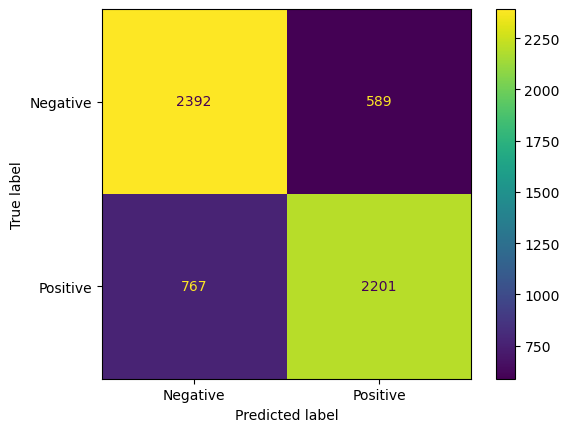

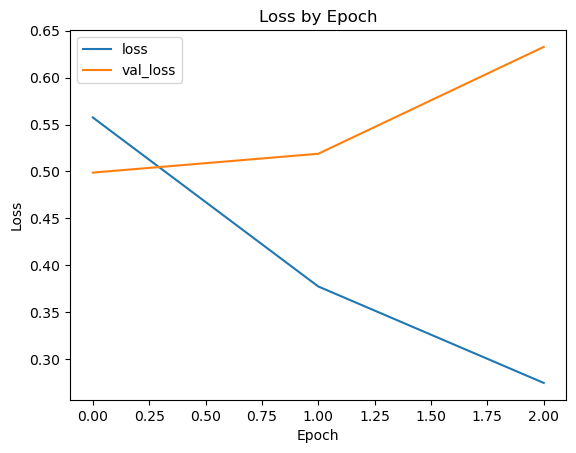

🏃 View run bilstm at: http://localhost:5000/#/experiments/9/runs/eed21d168a204d128e0526f8ab7a3e9c
🧪 View experiment at: http://localhost:5000/#/experiments/9


In [3]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": None,
        }
    )

Les résultats sont déséquilibrés entre les classes positives et négatives et il y a toujours un problème de sur-apprentissage.<br>
Essayons de changer déjà la couche de pooling puis ensutie d'ajouter des couches de régularisation.<br>

## Changement de la couche de pooling

A présent, je vais essayer de modifier la couche de pooling avec une couche en max pooling si cela améliore le résultat.<br>
Regardons si cela aide le modèle à mieux généraliser et réduire l'overfitting.<br>

In [2]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "p7_dl_models",
        "run_name": "bilstm",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 45,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 10,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": dl.custom_standardization_punct,  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(10, return_sequences=True, name="lstm1")
            ),
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(10, return_sequences=True, name="lstm2")
            ),
            tf.keras.layers.GlobalMaxPool1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D()
    },
    "weights": {
        "pretrained_weights": None,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-13 07:25:57.014575: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


/home/hedredo/miniconda310/envs/p7_tf_cpu/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025-01-13 07:26:15.837763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: 

Vocabulary size:  20657


2025-01-13 07:26:16.274418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-13 07:26:16.275750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-13 07:26:16.276915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 817ms/step


2025-01-13 07:27:22.854758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-13 07:27:22.856278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-13 07:27:22.857427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Evaluate on test data
 1/93 [..............................] - ETA: 4s - loss: 0.4979 - binary_accuracy: 0.7500 - auc: 0.8480

2025-01-13 07:27:30.965643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int8 and shape [5949]
	 [[{{node Placeholder/_1}}]]


186/186 [==============================] - 3s 18ms/step


,negative,positive,macro avg
precision,0.779932,0.771353,0.775642
recall,0.769205,0.782008,0.775607
f1-score,0.774531,0.776644,0.775588
support,2981.000000,2968.000000,5949.000000


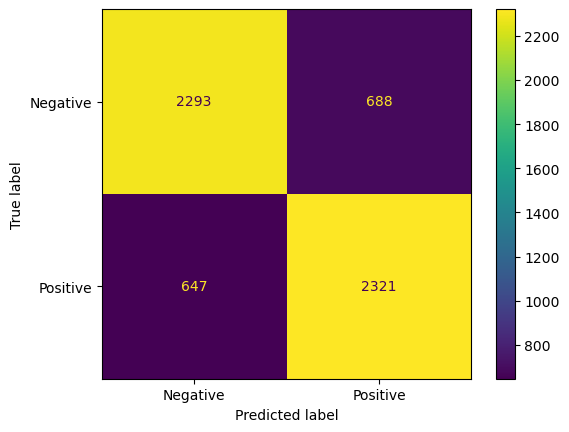

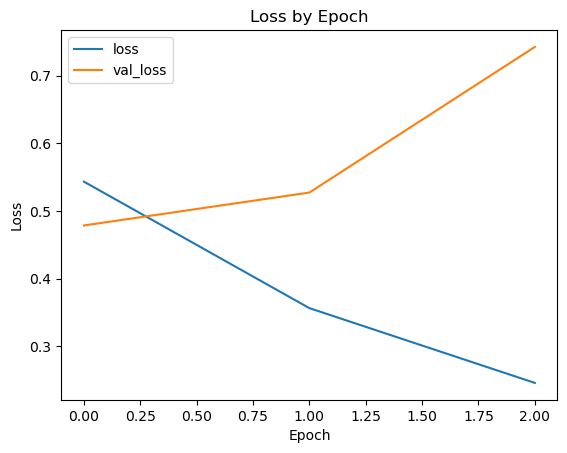

🏃 View run bilstm at: http://localhost:5000/#/experiments/9/runs/67248ef0c6164e87be4d3484b1c28199
🧪 View experiment at: http://localhost:5000/#/experiments/9


In [3]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": None,
        }
    )

Les résultats sont assez équilibrés sur les deux classes grâce au changement de la couche de pooling mais le modèle souffre toujours de sur-apprentissage.<br>

## Ajout des poids pré-entrainés glove-twitter-25

Testons maintenant l'ajout des poids pré-entrainés glove-twitter-25 tout en diminuant la couche d'embedding à 10 dimensions.<br>
Nous allons perdre une partie des informations des poids pré-entrainés mais jusqu'à maintenant les conserver n'avait pas permis d'améliorer les performances.<br>

In [2]:
# Load the glove-twitter-25 model
repo_id = "fse/glove-twitter-25"
model_file = hf_hub_download(repo_id=repo_id, filename="glove-twitter-25.model")
vector_file = hf_hub_download(
    repo_id=repo_id, filename="glove-twitter-25.model.vectors.npy"
)
glove = KeyedVectors.load(model_file, mmap="r")

In [3]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "test_dl_models",
        "run_name": "bilstm",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 45,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 10,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": dl.custom_standardization_punct,  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(10, return_sequences=True, name="lstm1")
            ),
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(10, return_sequences=True, name="lstm2")
            ),
            tf.keras.layers.GlobalMaxPool1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D()
    },
    "weights": {
        "pretrained_weights": glove,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-3,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-13 07:28:46.375048: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


/home/hedredo/miniconda310/envs/p7_tf_cpu/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025-01-13 07:28:57.542726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: 

Vocabulary size:  20657


2025-01-13 07:28:58.298296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-13 07:28:58.299465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-13 07:28:58.300237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 769ms/step


2025-01-13 07:30:07.629361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-13 07:30:07.630550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-13 07:30:07.631349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Evaluate on test data
186/186 [==============================] - 3s 18ms/step


,negative,positive,macro avg
precision,0.751570,0.820661,0.786115
recall,0.843341,0.720013,0.781677
f1-score,0.794815,0.767050,0.780932
support,2981.000000,2968.000000,5949.000000


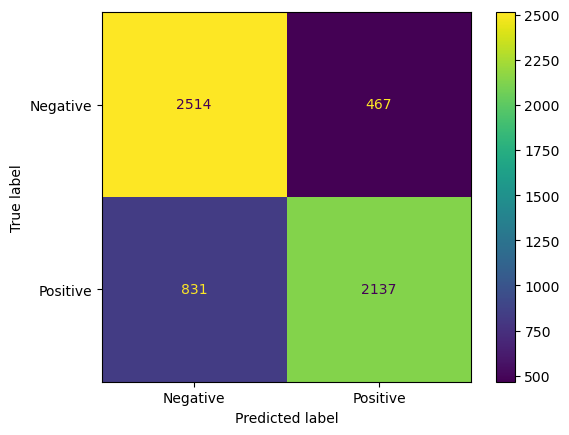

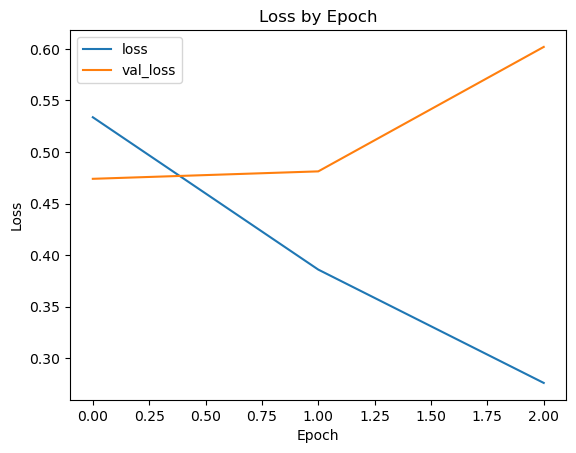

🏃 View run bilstm at: http://localhost:5000/#/experiments/11/runs/a9b202f8a0d24b3ba5cf3f720185c808
🧪 View experiment at: http://localhost:5000/#/experiments/11


In [4]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": repo_id,
        }
    )

Bien que les résultats sont encourageants, il est à noter que le modèle a un déséquilibre entre les classes positives et négatives.<br>
Ce modèle prédit bien mieux les résultats négatifs, ce qui toutefois pourrait être intérressé pour anticiper les bad buzz.<br>
Cependant, il pourrait aussi provoquer de fausses alertes sur des tweets positifs.<br>

## Ajout de couches de dropout

Les résultats sur le jeu de test se sont améliorés mais au détriment d'une classe.<br>
Tentons de réduire l'overfitting à présent en ajoutant des couches de dropout.<br>

In [2]:
# Load the glove-twitter-25 model
repo_id = "fse/glove-twitter-25"
model_file = hf_hub_download(repo_id=repo_id, filename="glove-twitter-25.model")
vector_file = hf_hub_download(
    repo_id=repo_id, filename="glove-twitter-25.model.vectors.npy"
)
glove = KeyedVectors.load(model_file, mmap="r")

In [3]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "test_dl_models",
        "run_name": "bilstm_regularized_10",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 45,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 10,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": dl.custom_standardization_punct,  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(10, return_sequences=True, name="lstm1")
            ),
            Dropout(0.2),
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(10, return_sequences=True, name="lstm2")
            ),
            Dropout(0.2),
            tf.keras.layers.GlobalMaxPooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D()
    },
    "weights": {
        "pretrained_weights": glove,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-4,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-13 08:11:15.254380: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


/home/hedredo/miniconda310/envs/p7_tf_cpu/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025-01-13 08:11:34.030630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: 

Vocabulary size:  20657


2025-01-13 08:11:34.528304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-13 08:11:34.529521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-13 08:11:34.530475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 766ms/step


2025-01-13 08:15:46.465978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-13 08:15:46.467356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-13 08:15:46.468418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Evaluate on test data
 9/93 [=>............................] - ETA: 1s - loss: 0.4850 - binary_accuracy: 0.7674 - auc: 0.8525

2025-01-13 08:15:55.504645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int8 and shape [5949]
	 [[{{node Placeholder/_1}}]]


186/186 [==============================] - 3s 18ms/step


,negative,positive,macro avg
precision,0.793498,0.758730,0.776114
recall,0.745052,0.805256,0.775154
f1-score,0.768512,0.781301,0.774907
support,2981.000000,2968.000000,5949.000000


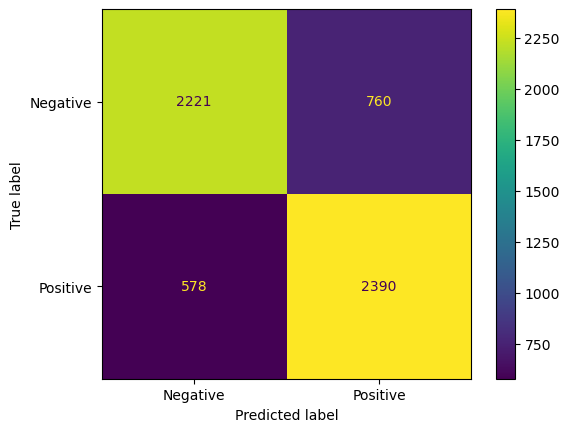

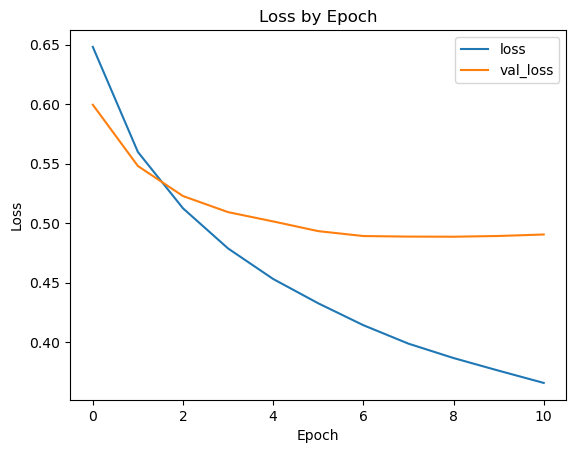

🏃 View run bilstm_regularized_10 at: http://localhost:5000/#/experiments/11/runs/1b03e6341a8544c1a44a6a8ad900a1e7
🧪 View experiment at: http://localhost:5000/#/experiments/11


In [4]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": repo_id,
        }
    )

Les couches de dropout ont significativement amélioré les résultats sur le jeu de test et on voit que le modèle généralise mieux sur les courbes d'apprentissage.<br>

## Comparaison avec la dimension d'embedding à 25

Nous allons tester à nouveau le modèle mais en conservant la dimension d'embedding original à 25.<br>
La capacité du modèle sera donc augmentée et risque d'amener à un overfitting plus important.<br>

In [2]:
# Load the glove-twitter-25 model
repo_id = "fse/glove-twitter-25"
model_file = hf_hub_download(repo_id=repo_id, filename="glove-twitter-25.model")
vector_file = hf_hub_download(
    repo_id=repo_id, filename="glove-twitter-25.model.vectors.npy"
)
glove = KeyedVectors.load(model_file, mmap="r")

In [3]:
# Please restart the kernel before running this cell to free up GPU memory

# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

# Parameters run for the model
params = {
    "mlflow": {
        "experiment_name": "test_dl_models",
        "run_name": "bilstm_regularized_25",
    },  # Always change the run_name
    "dataset": {
        "col_name": "tokenized_text",
        "val_split": 0.2,  # default 0.2
        "batch_size": 64,  # default 32
    },
    "model": {
        "max_tokens": None,  # Keep it low to reasonnable training time and help against overfitting
        "seq_length": 45,  # Moyenne de tokens par texte : 25 - 50 - 75 - 100 (attention pour BERT, cela compte les sous tokens et ont souvent une valeur prédifinie fixe telle que 128, 256, 512)
        "embedding_dim": 25,  # Values to try 10, 15, 25, 50 (compute vocabsize**0.25)
        "embeddings_initializer": RandomUniform(
            -0.1, 0.1
        ),  # Try RandomUniform(-0.1, 0.1), TruncatedNormal(mean=0.0, stddev=0.01), GlorotUniform(seed=SEED), GlorotNormal(seed=SEED)
        "embedding_trainable": True,
        "text_standardize_func": dl.custom_standardization_punct,  # Values to try : "lower", dl.custom_standardization_punct, dl.custom_standardization_nopunct_digits
        "epochs": 40,
        "additionnal_layers": (
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(10, return_sequences=True, name="lstm1")
            ),
            Dropout(0.2),
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(10, return_sequences=True, name="lstm2")
            ),
            Dropout(0.2),
            tf.keras.layers.GlobalMaxPooling1D(),
        ),  # values to try : ( GlobalAveragePooling1D(), GlobalMaxPool1D()
    },
    "weights": {
        "pretrained_weights": glove,  # Values to try : None, "glove-twitter-25", "glove-twitter-100", glove-twitter-50", w2c, fasttext
        "initializer_method": "normal",  # normal or uniform
        "initializer_range": 0.05,  # Scale for normal or limit for uniform
    },
    "optimizer": {
        "learning_rate": tf.keras.optimizers.schedules.ExponentialDecay(
            5e-4,
            decay_steps=298,
            decay_rate=0.9,
            staircase=True,
        ),
        "epsilon": 1e-07,  # default 1e-07
    },
}


# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = params["mlflow"]["experiment_name"]
assert params["dataset"]["col_name"] in cols, "Column name not found in the dataset"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

2025-01-13 07:40:26.425169: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


/home/hedredo/miniconda310/envs/p7_tf_cpu/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025-01-13 07:40:37.491536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: 

Vocabulary size:  20657


2025-01-13 07:40:37.974445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-13 07:40:37.975859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-13 07:40:37.976986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 829ms/step


2025-01-13 07:45:26.412658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-13 07:45:26.414621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-13 07:45:26.415693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Evaluate on test data
 9/93 [=>............................] - ETA: 1s - loss: 0.4824 - binary_accuracy: 0.7569 - auc: 0.8534

2025-01-13 07:45:35.495130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int8 and shape [5949]
	 [[{{node Placeholder/_1}}]]


186/186 [==============================] - 3s 18ms/step


,negative,positive,macro avg
precision,0.780355,0.770302,0.775328
recall,0.767528,0.783019,0.775273
f1-score,0.773888,0.776608,0.775248
support,2981.000000,2968.000000,5949.000000


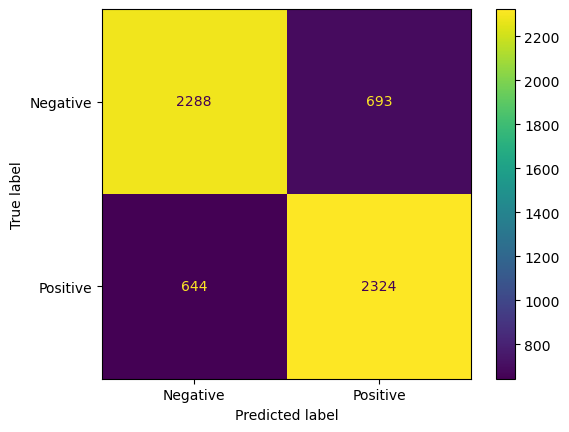

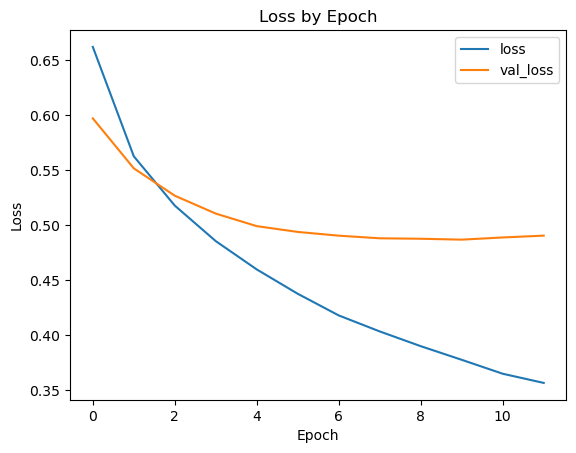

🏃 View run bilstm at: http://localhost:5000/#/experiments/11/runs/3e854ac986df447daffd7b8cd869e12b
🧪 View experiment at: http://localhost:5000/#/experiments/11


In [4]:
# Align the splits with the corpus directly from dataframe
data = dl.filter_split_dataset(
    X_train_full,
    X_test_full,
    y_train,
    y_test,
    [params["dataset"]["col_name"]],
    validation_split=params["dataset"]["val_split"],
)
# Create the mlflow datasets for log dataset input
train_mlflow, val_mlflow, test_mlflow = dl.create_mlflow_dataset(data)
# Create the tensorflow dataset
train_ds, val_ds, test_ds = dl.to_tensorflow_dataset(
    data, params["dataset"]["batch_size"]
)

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=False)
with mlflow.start_run(run_name=params["mlflow"]["run_name"]) as active_run:
    # Log the datasets prepared for mlflow
    mlflow.log_input(train_mlflow, context="training")
    mlflow.log_input(val_mlflow, context="validation")
    mlflow.log_input(test_mlflow, context="test")
    # Create & build the model with defined parameters
    model = dl.create_tf_model(
        train_ds, params["model"], params["optimizer"], params["weights"]
    )
    model.get_layer("embedding").trainable = params["model"]["embedding_trainable"]
    model.build(input_shape=(None, 1))

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["model"]["epochs"],
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        ],
    )

    # Evaluate the model
    print("Evaluate on test data")
    print("==============")
    start_time = time.time()
    loss, accuracy, auc = model.evaluate(test_ds)
    inference_time = time.time() - start_time
    # Use classification report
    _, _, _, _, X_test, y_test = data
    y_pred = model.predict(X_test)
    predictions = (y_pred > 0.5).astype(int)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_binary_accuracy"][
                indice_best_val_loss
            ],
            "roc_auc": auc,
            "val_roc_auc": history.history["val_auc"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": params["dataset"]["col_name"],
            "standardization": params["model"]["text_standardize_func"],
            "test_size_ratio": params["dataset"]["val_split"],
            "validation_split_": params["dataset"]["val_split"],
            "pretrained_weights": repo_id,
        }
    )

En conclusion, le modèle a effectivement sur-appris avec une dimension d'embedding à 25.<br>
Il faudrait augmenter la taille du jeu de données d'entrainement pour voir si le modèle peut mieux généraliser.<br>
Cependant comme nous n'avons pas les ressources nécessaires, nous arreterons donc les expériences ici.<br>

## Résultats

In [19]:
# Récupération des résultats de l'expériementation
df_runs = utils.get_mlflow_results("p7_dl_models")
# Afficher les colonnes sélectionnées et filtrage des expériences
df_runs.loc[df_runs["tag_mlflow.runName"] == "bilstm", :].sort_values(
    ["metric_validation_loss"], ascending=True
).filter(
    [
        "param_pretrained_weights",
        "param_data_preparation",
        "param_standardization",
        "metric_validation_loss",
        "metric_val_accuracy",
        "metric_val_roc_auc",
        "metric_log_loss",
        "metric_accuracy_score",
        "metric_roc_auc",
        "metric_inference_time",
    ]
).head(3)

,param_pretrained_weights,param_data_preparation,param_standardization,metric_validation_loss,metric_val_accuracy,metric_val_roc_auc,metric_log_loss,metric_accuracy_score,metric_roc_auc,metric_inference_time
4,None,tokenized_text,<function custom_standardization_punct at 0x7f...,0.632576,0.764026,0.845257,0.491812,0.772063,0.850703,1.301648
1,None,tokenized_text,<function custom_standardization_punct at 0x7f...,0.635923,0.765287,0.843231,0.497775,0.769877,0.845017,1.863024
0,None,tokenized_text,<function custom_standardization_punct at 0x7f...,0.742496,0.770120,0.852862,0.474917,0.775593,0.855883,2.015086


# Comparaison des résultats

Regardons les résultats depuis l'interface de MLFlow pour voir les performances des modèles sur le jeu de test.<br>
Les résultats sont triés par accuracy sur le jeu de test.<br>
Au final le modèle scratch sans poids a assez bien performé et la fonction de standardisation 1 a donc eu son importance dans les résultats en dehors de l'architecture du modèle.<br>
Nous avons vu lors de l'analyse que les tweets comportant beaucoup d'argot et que même avec des poids pré-entrainés, un modèle sans poids réussit à bien fonctionner et saisir les informations correctement.<br>
Les changements finaux d'architecture nous ont permis de réduire l'overfitting mais sans grandement améliorer les résultats.<br>


**Le fait que la taille du jeu de données ne soit pas conséquente est un facteur limitant pour les performances des modèles.**

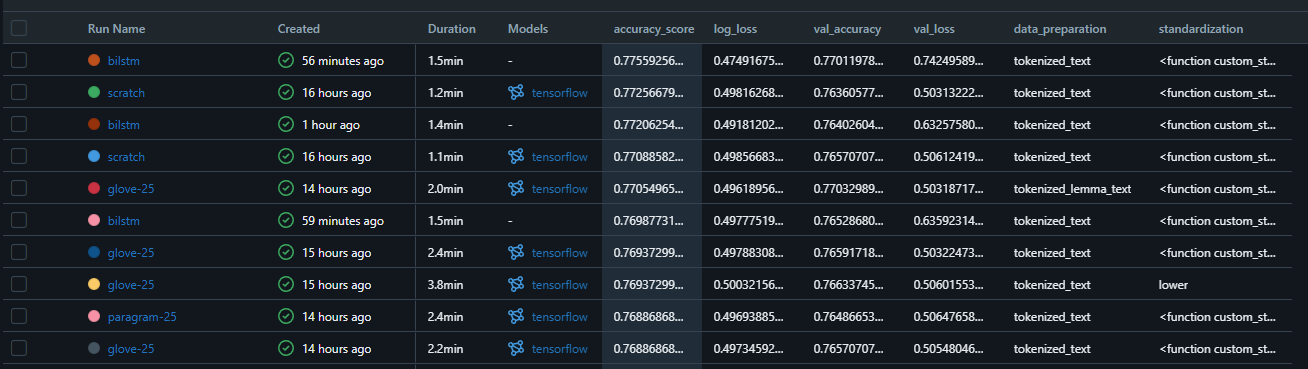

# Test du modèle scratch pour la production

Testons le modèle `scratch` qui est un bon compromis en terme de légereté et de performances.<br>
Ainsi nous pourrons déployer un modèle léger et performant.<br>
Je vais charger ici un kernel **cpu** qui servira pour le déploiement du modèle tout en conservant la version tensorflow 2.10 'cpu' qui a été utilisée.<br>
Je vais reproduire certains éléments de l'environnement de test pour pouvoir charger le modèle et le tester.<br>

In [1]:
# Load the necessary modules
import mlflow.tensorflow
import os
from func import (
    SpacyTokenizer,
    custom_standardization_punct,  # Necessary to import the custom_standardization_punct function
)
from dotenv import load_dotenv

2025-01-13 09:09:21.374594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Don't forget to load the serialized functions
load_dotenv()

# Instantiate the tokenizer
tokenizer_path = os.getenv("TOKENIZER_PATH")
model_path = os.getenv("MODEL_PATH")
tokenizer = SpacyTokenizer(tokenizer_path)
nn_model = mlflow.tensorflow.load_model(model_path)

/home/hedredo/miniconda310/envs/p7_tf_cpu/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.8.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
2025-01-13 09:09:25.041888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-13 09:09:25.043522: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_paralleli

In [3]:
text = "@helloworld #forlife I am a happy person"
nn_model.predict(tokenizer.tokenize([text]))

1/1 [==============================] - 0s 83ms/step


array([[0.7948212]], dtype=float32)

On va procéder à l'enregistrement du modèle pour signaler qu'il s'agit de la version à passer en production.<br>

In [6]:
from mlflow.tracking import MlflowClient
import mlflow

In [11]:
model_name = "neuralnet"
# Enregistrement du modèle dans le registre
model_version = mlflow.register_model(model_uri=model_path, name=model_name)

Registered model 'neuralnet' already exists. Creating a new version of this model...
Created version '1' of model 'neuralnet'.


In [12]:
# Promouvoir la version 1 du modèle vers le stage 'Production'
client = MlflowClient()
client.transition_model_version_stage(
    name=model_name,
    version=1,
    stage="Production",
    archive_existing_versions=True,  # Optionnel : archive les versions antérieures
)

print(f"Version 1 du modèle '{model_name}' est maintenant en Production.")

Version 1 du modèle 'neuralnet' est maintenant en Production.


/tmp/ipykernel_42690/3000337762.py:3: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


In [ ]:
client.transition_model_version_stage(
    name="spacy_en_core_web_sm",
    version=1,
    stage="Production",
    archive_existing_versions=True,  # Optionnel : archive les versions antérieures
)